In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 9.4 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
# import matplotlib.pyplot as plt
# plt.rcParams.update({
#     "font.size": 12,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Times New Roman"]
# })

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import shap
from sklearn.utils import resample
import time

print("Step 1: Libraries imported successfully.")

Step 1: Libraries imported successfully.


In [ ]:
# Step 2: Upload data files
# print("\nStep 2: Uploading data files...")
# from google.colab import files
# uploaded = files.upload()

# Load data files
group_species_df = pd.read_csv("/content/drive/MyDrive/code/IBD/uc_vs_hc_after_filtered_10%/uc_group_abundance_with_group.tsv", sep='\t')
specific_species_df = pd.read_csv("/content/drive/MyDrive/code/IBD/uc_vs_hc_after_filtered_10%/uc_specific_abundance_with_group.tsv", sep='\t')
print("Data files loaded successfully.")

Data files loaded successfully.


In [ ]:
# Step 3: Data preparation and feature weighting
print("\nStep 3: Preparing data and applying weights to specific species...")
start_time = time.time()


labels = group_species_df.iloc[0, 1:]
labels_binary = labels.replace({"UC": 1, "HC": 0}).astype(int).reset_index(drop=True)


group_species_features = group_species_df.iloc[1:, 1:].copy()


group_species_features.index = [
    name.split('s__')[-1] if 's__' in name else name for name in group_species_df.iloc[1:, 0]
]


group_species_features.columns = labels.index


specific_species_features = specific_species_df.iloc[1:, 1:].copy()
specific_species_features.index = [
    name.split('s__')[-1] if 's__' in name else name for name in specific_species_df.iloc[1:, 0]
]
specific_species_features.columns = labels.index

# Weight the strain-specific columns in `group_species_features`.
weight_factor = 2.0
group_species_features = group_species_features.apply(pd.to_numeric, errors='coerce').fillna(0)
specific_species_features = specific_species_features.apply(pd.to_numeric, errors='coerce').fillna(0)
group_species_features.loc[specific_species_features.index] *= weight_factor

# Transpose the feature matrix so that the samples are rows and the features are columns
X = group_species_features.T
y = labels_binary.reset_index(drop=True)

print(f"Data preparation completed in {time.time() - start_time:.2f} seconds.")



Step 3: Preparing data and applying weights to specific species...


<ipython-input-5-58433150cc39>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_binary = labels.replace({"UC": 1, "HC": 0}).astype(int).reset_index(drop=True)


Data preparation completed in 0.27 seconds.


In [ ]:
# Step 4: Split data into train and test sets
print("\nStep 4: Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split completed.")


Step 4: Splitting data into training and testing sets...
Data split completed.



Step 5: Defining models and starting 10-fold cross-validation...

Training and evaluating model: Logistic Regression...
10-fold CV completed for Logistic Regression in 7.66 seconds. Mean AUC: 0.85

Training and evaluating model: Support Vector Classifier...
10-fold CV completed for Support Vector Classifier in 4.24 seconds. Mean AUC: 0.83

Training and evaluating model: Random Forest...
10-fold CV completed for Random Forest in 3.73 seconds. Mean AUC: 0.94

Training and evaluating model: XGBoost...
10-fold CV completed for XGBoost in 11.45 seconds. Mean AUC: 0.95

Training and evaluating model: LightGBM...
[LightGBM] [Info] Number of positive: 277, number of negative: 288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10050
[LightGBM] [Info] Number of data points in the train set:

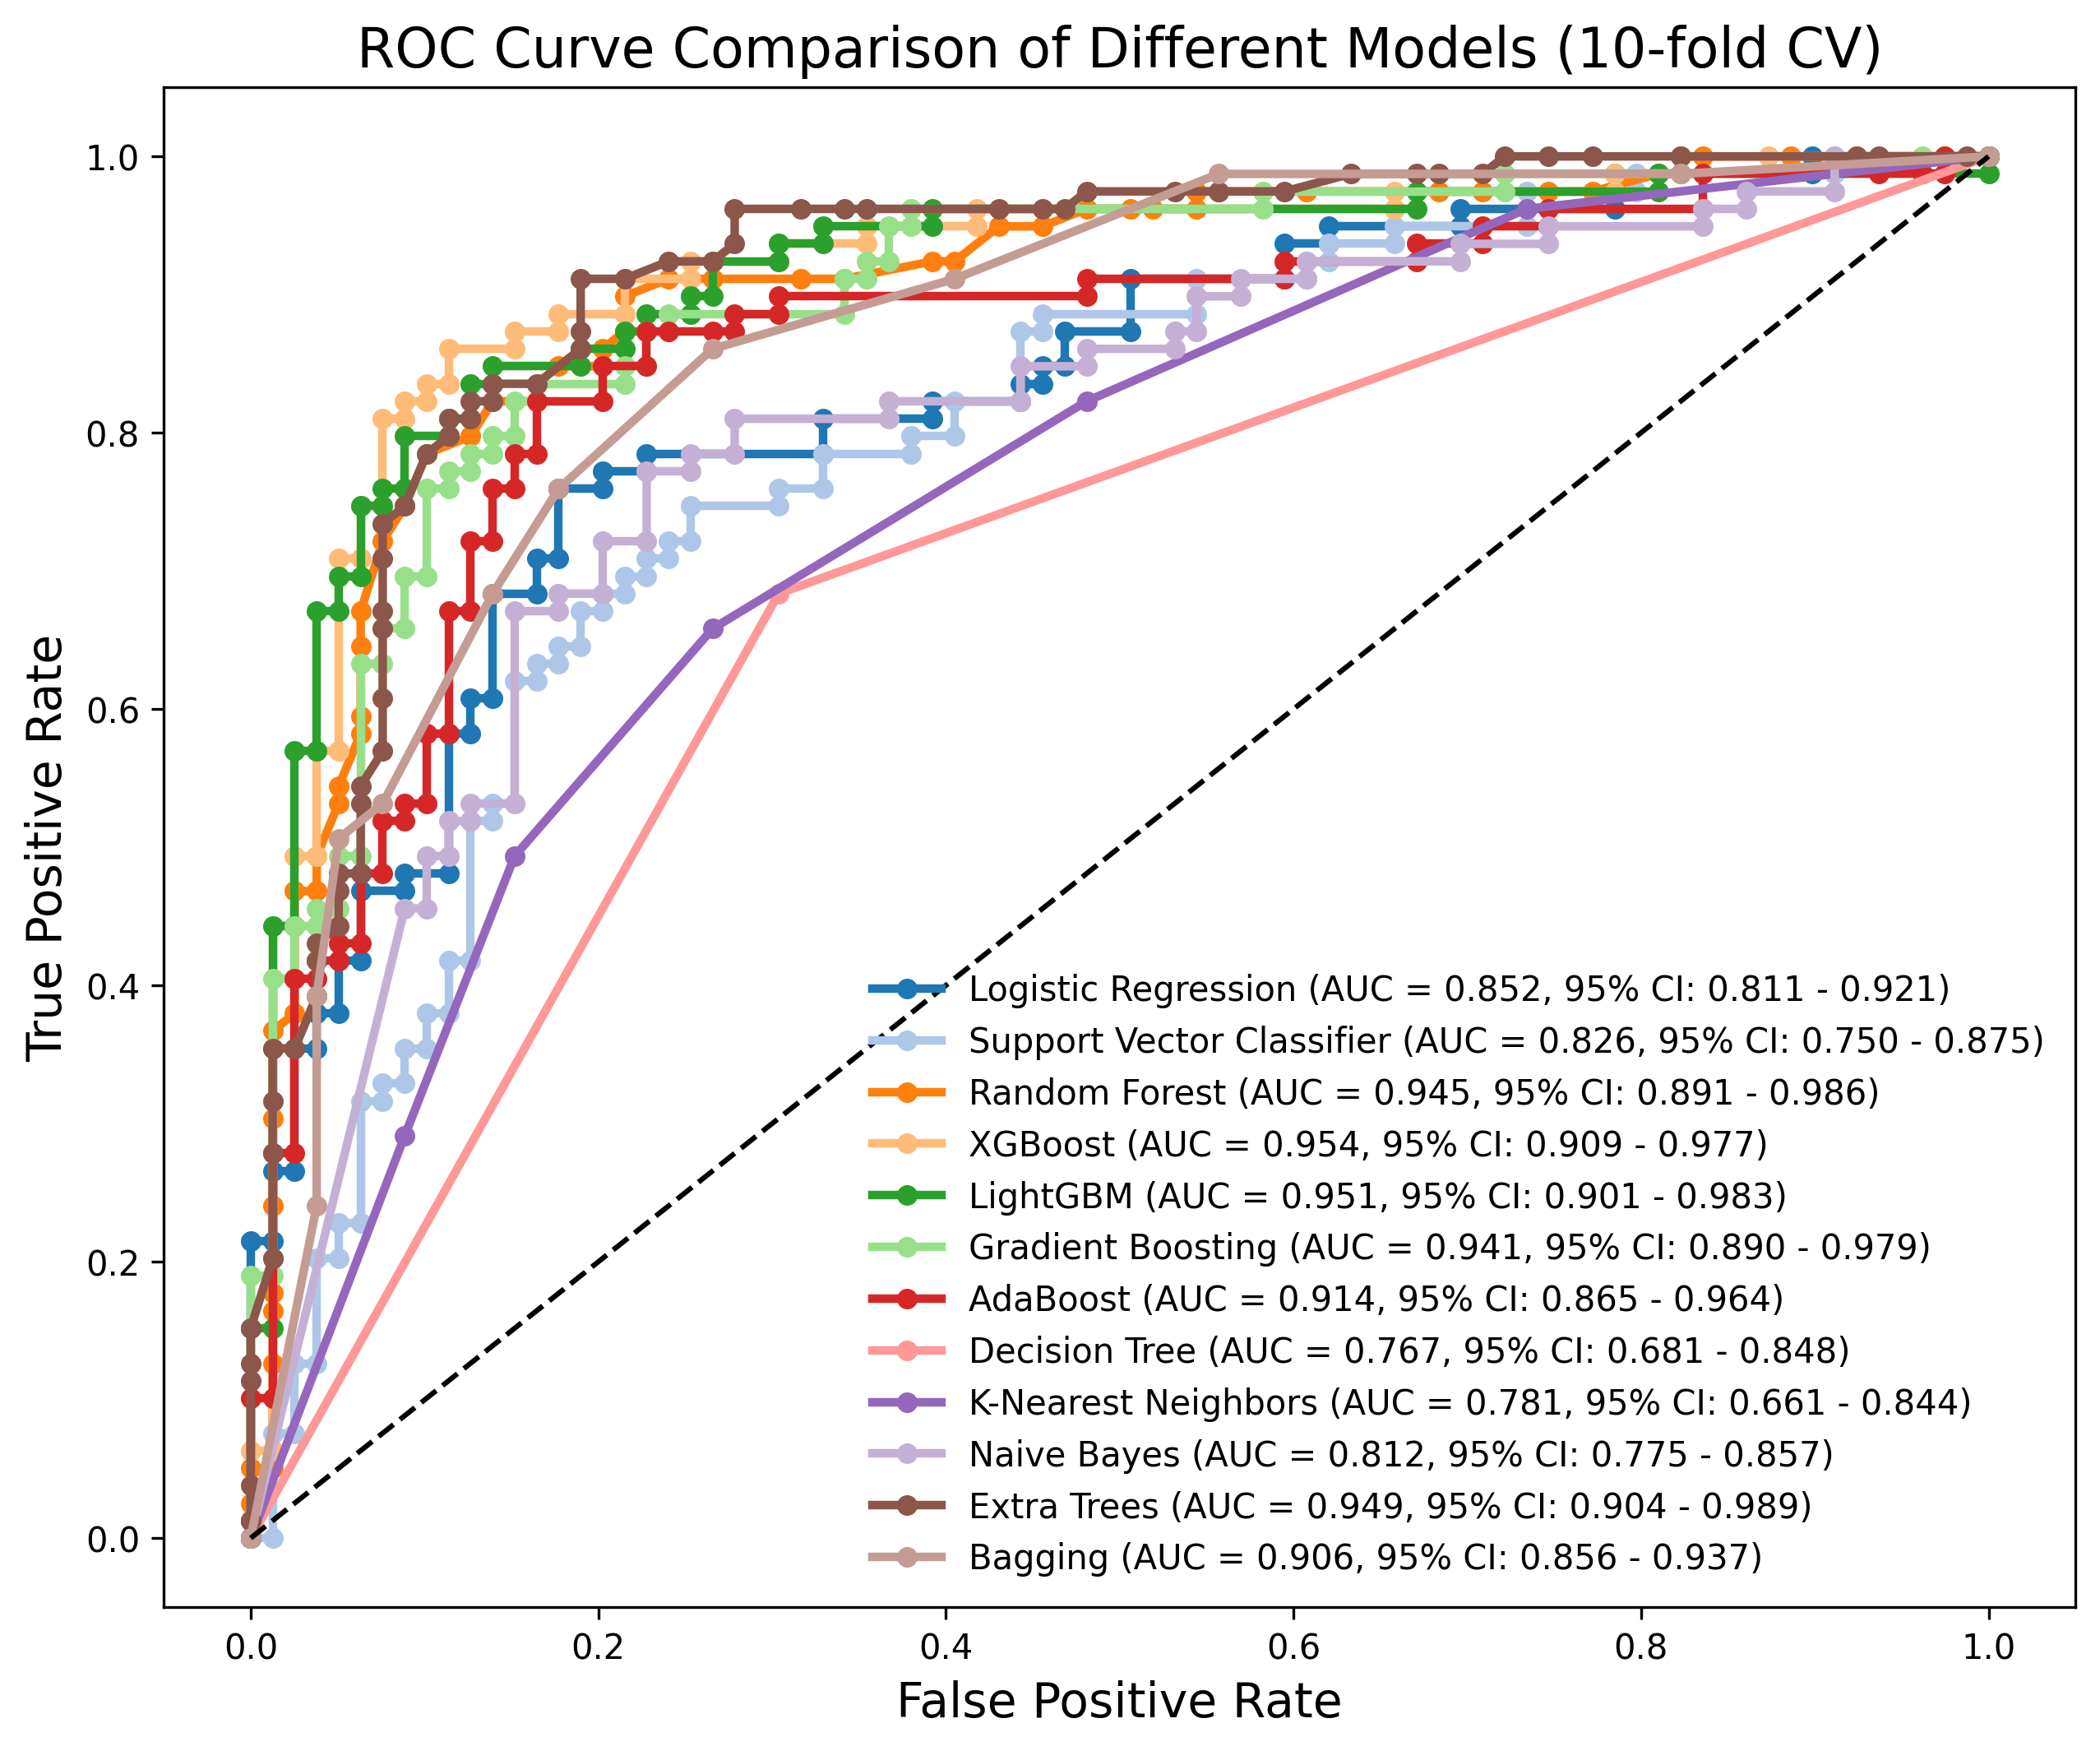

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from cycler import cycler

# Step 5: Define models and 10-fold cross-validation
print("\nStep 5: Defining models and starting 10-fold cross-validation...")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Classifier': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Extra Trees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10) # Use 'estimator' instead of 'base_estimator'
}

# 10-fold cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model_auc_scores = {}


colors = plt.cm.tab20.colors[:12]
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

# Plot ROC curves for each model
plt.figure(figsize=(10, 8), dpi=300)
# n_bootstraps = 1000  # Set bootstrap count for CI calculation

# for model_name, model in models.items():
#     print(f"\nTraining and evaluating model: {model_name}...")
#     start_time = time.time()

#     # Cross-validate model and calculate mean AUC
#     cv_auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
#     mean_auc = cv_auc_scores.mean()
#     model_auc_scores[model_name] = mean_auc

#     print(f"10-fold CV completed for {model_name} in {time.time() - start_time:.2f} seconds. Mean AUC: {mean_auc:.2f}")

#     # Train model on full train set to plot ROC on test set
#     model.fit(X_train, y_train)
#     y_pred_prob = model.predict_proba(X_test)[:, 1]

#     # Compute ROC curve and AUC on the test set
#     fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
#     roc_auc = auc(fpr, tpr)

#     # Calculate CI for the current model using bootstrap
#     bootstrap_auc_scores = []
#     for _ in range(n_bootstraps):
#         X_resampled, y_resampled = resample(X_test, y_test)
#         y_pred_prob_resampled = model.predict_proba(X_resampled)[:, 1]
#         auc_score = roc_auc_score(y_resampled, y_pred_prob_resampled)
#         bootstrap_auc_scores.append(auc_score)

#     ci_lower = np.percentile(bootstrap_auc_scores, 2.5)
#     ci_upper = np.percentile(bootstrap_auc_scores, 97.5)

#     # Plot ROC curve with AUC and CI in label
#     plt.plot(fpr, tpr, linewidth=2.5, marker='o', markersize=5, label=f'{model_name} (AUC = {roc_auc:.3f}, 95% CI: {ci_lower:.3f} - {ci_upper:.3f})')

for model_name, model in models.items():
    print(f"\nTraining and evaluating model: {model_name}...")
    start_time = time.time()

    # Cross-validate model and calculate mean AUC and CI
    cv_auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    mean_auc = cv_auc_scores.mean()
    ci_lower, ci_upper = np.percentile(cv_auc_scores, [2.5, 97.5])
    model_auc_scores[model_name] = mean_auc

    print(f"10-fold CV completed for {model_name} in {time.time() - start_time:.2f} seconds. Mean AUC: {mean_auc:.2f}")


    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve with mean AUC and CI in label
    plt.plot(fpr, tpr, linewidth=2.5, marker='o', markersize=5, label=f'{model_name} (AUC = {mean_auc:.3f}, 95% CI: {ci_lower:.3f} - {ci_upper:.3f})')


# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison of Different Models (10-fold CV)', fontsize=16)
plt.legend(loc='lower right', frameon=False, fontsize=10)
plt.show()
plt.savefig("/content/drive/MyDrive/code/IBD/uc_vs_hc_after_filtered_10%/ROC_Curve.png", format="png", dpi=300, bbox_inches="tight")  # bbox_inches="tight" 去除多余空白


In [ ]:
# Step 6: Choose the best model based on cross-validation AUC
best_model_name = max(model_auc_scores, key=model_auc_scores.get)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with Cross-Validation AUC: {model_auc_scores[best_model_name]:.2f}")



Best Model: XGBoost with Cross-Validation AUC: 0.95


In [ ]:
# Step 7: Train the best model on the entire training set and evaluate on the test set
print(f"\nTraining the best model ({best_model_name}) on the full training set...")
start_time = time.time()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
print(f"Best model training completed in {time.time() - start_time:.2f} seconds.")

# Compute performance metrics on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nTest Set Performance Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")



Training the best model (XGBoost) on the full training set...
Best model training completed in 2.20 seconds.

Test Set Performance Metrics:
Accuracy: 0.85
Precision: 0.91
Recall: 0.77
F1 Score: 0.84


# Step 8: Calculate 95% CI for AUC using Bootstrap


In [ ]:
# Step 8: Calculate 95% CI for AUC using Bootstrap
n_bootstraps = 1000
bootstrap_auc_scores = []

for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_test, y_test)
    y_pred_prob_resampled = best_model.predict_proba(X_resampled)[:, 1]
    auc_score = roc_auc_score(y_resampled, y_pred_prob_resampled)
    bootstrap_auc_scores.append(auc_score)

# Calculate 95% CI
auc_mean = np.mean(bootstrap_auc_scores)
ci_lower = np.percentile(bootstrap_auc_scores, 2.5)
ci_upper = np.percentile(bootstrap_auc_scores, 97.5)

print(f"AUC = {auc_mean:.2f} (95% CI: {ci_lower:.2f} - {ci_upper:.2f})")


AUC = 0.92 (95% CI: 0.87 - 0.96)


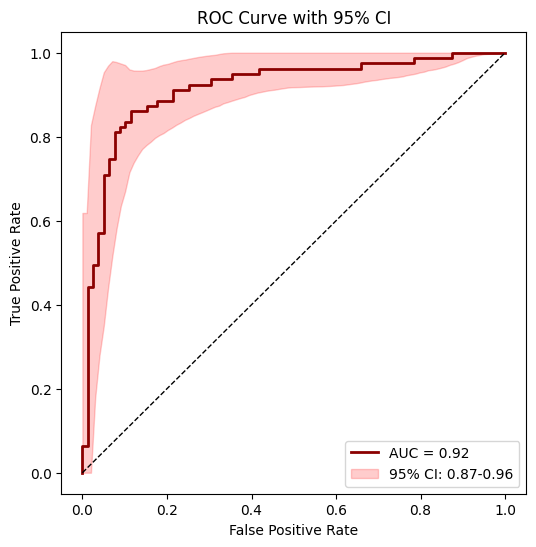

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import resample


# Step 8: Calculate 95% CI for AUC using Bootstrap
n_bootstraps = 1000
bootstrap_auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_test, y_test)
    y_pred_prob_resampled = best_model.predict_proba(X_resampled)[:, 1]
    fpr, tpr, _ = roc_curve(y_resampled, y_pred_prob_resampled)
    auc_score = roc_auc_score(y_resampled, y_pred_prob_resampled)
    bootstrap_auc_scores.append(auc_score)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

# Calculate 95% CI for AUC
auc_mean = np.mean(bootstrap_auc_scores)
ci_lower = np.percentile(bootstrap_auc_scores, 2.5)
ci_upper = np.percentile(bootstrap_auc_scores, 97.5)


plt.figure(figsize=(6, 6))

y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='darkred', lw=2, label=f'AUC = {auc_mean:.2f}')


tprs = np.array(tprs)
mean_tpr = tprs.mean(axis=0)
std_tpr = tprs.std(axis=0)
tpr_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)

plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='red', alpha=0.2, label=f'95% CI: {ci_lower:.2f}-{ci_upper:.2f}')


plt.plot([0, 1], [0, 1], 'k--', lw=1)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with 95% CI")
plt.legend(loc='lower right')


plt.show()
plt.savefig("/content/drive/MyDrive/code/IBD/uc_vs_hc_after_filtered_10%/BestModel_OnTestData_ROC_Curve.png", format="png", dpi=300, bbox_inches="tight")  # bbox_inches="tight" 去除多余空白

In [ ]:
!pip install shap --upgrade

In [ ]:
# Read the list of commensal bacteria from the file
common_species_df = pd.read_csv('/content/drive/MyDrive/code/IBD/uc_vs_hc_after_filtered_10%/common_species_names.tsv', sep='\t')

# Convert the list of commensal bacteria into a list
common_species_list = common_species_df.iloc[:, 0].tolist()

# Species name after extraction of s__
common_species_list = common_species_df.iloc[:, 0].apply(lambda x: x.split('s__')[-1]).tolist()


Performing SHAP analysis for model interpretability...

Generating custom-colored SHAP bar plot...

Generating SHAP beeswarm plot with consistent colors...


<ipython-input-23-e561adf7dc67>:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for color bar


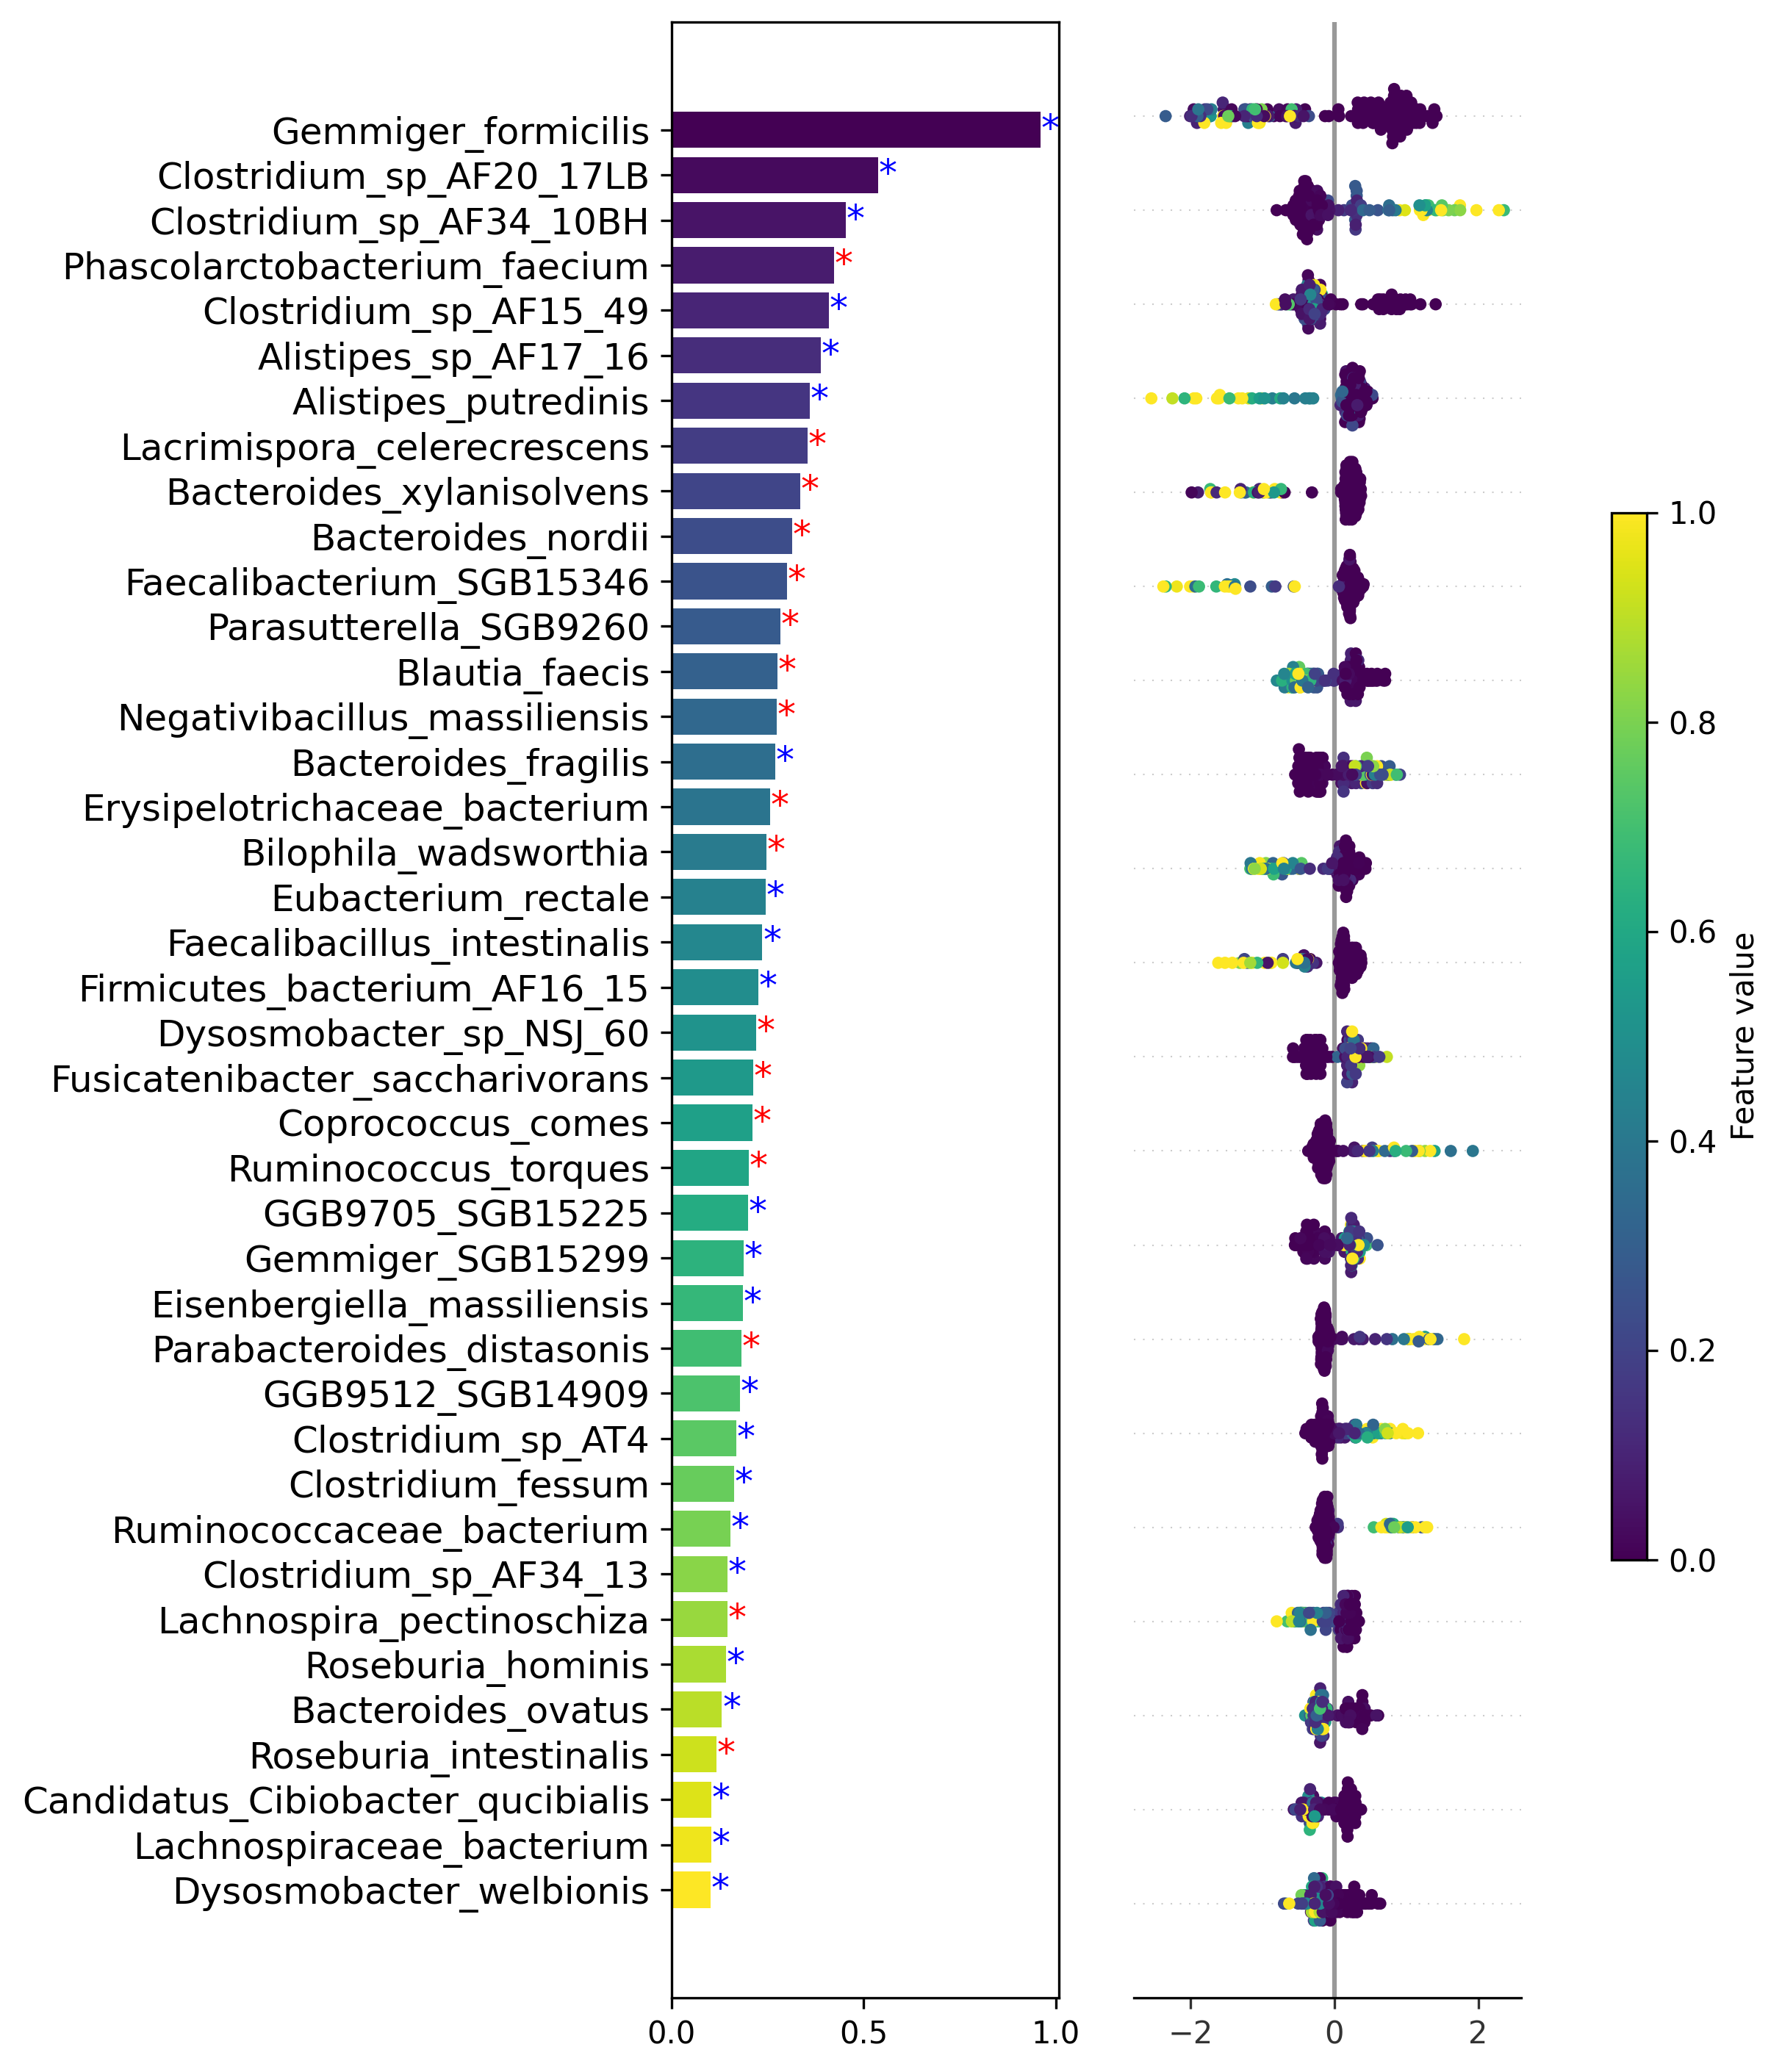

In [ ]:
import matplotlib.pyplot as plt
import shap
import numpy as np
import pandas as pd

# Set font for all plots
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10  # Global font size for readability
plt.rcParams['axes.titlesize'] = 10  # Title font size
plt.rcParams['axes.labelsize'] = 10  # Axis label font size
plt.rcParams['xtick.labelsize'] = 10  # X-tick label size
plt.rcParams['ytick.labelsize'] = 10  # Y-tick label size

# SHAP Analysis for model interpretability
print("\nPerforming SHAP analysis for model interpretability...")
explainer = shap.TreeExplainer(best_model)

# Generate SHAP values using explainer on X_test
shap_values_explanation = explainer(X_test)
shap_values = shap_values_explanation

# Create figure and set size to align both plots
fig, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=300)
fig.subplots_adjust(wspace=0.6)  # Slightly increase space between the two plots

# 1. Custom-colored SHAP bar plot
print("\nGenerating custom-colored SHAP bar plot...")
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test.columns

# Store feature importance in DataFrame and sort by importance
importance_df = pd.DataFrame({'feature': feature_names, 'importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(40)

# Custom colors
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))

# Plot custom bar plot
axes[0].barh(importance_df['feature'], importance_df['importance'], color=colors)
axes[0].invert_yaxis()

# Add star markers for specific species
specific_species = specific_species_features.index.tolist()  # Get list of specific species
# for i, feature in enumerate(importance_df['feature']):
#     if feature in specific_species:
#         # Add a star next to the bar to mark specific species
#         axes[0].text(importance_df['importance'].iloc[i] + 0.01, i, '*',
#                      ha='left', va='center', color='red', fontsize=12)
for i, feature in enumerate(importance_df['feature']):
    if feature in specific_species:
        # Add a red star for specific species
        axes[0].text(importance_df['importance'].iloc[i] + 0.001, i, '*', ha='left', va='center', color='red', fontsize=12)
    elif feature in common_species_list:
        # Add a blue star for common species
        axes[0].text(importance_df['importance'].iloc[i] + 0.001, i, '*', ha='left', va='center', color='blue', fontsize=12)

# Hide x-axis label and title by setting them as empty strings
axes[0].set_xlabel("")  # Hide x-axis label for the bar plot
axes[0].set_title("")   # Hide title for the bar plot
axes[0].tick_params(axis='y', labelsize=12)  # Increase font size for feature names

# Set consistent x-axis tick parameters for the bar plot
axes[0].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# 2. SHAP beeswarm plot with consistent colors
print("\nGenerating SHAP beeswarm plot with consistent colors...")
plt.sca(axes[1])
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=20, show=False, color_bar=False, cmap="viridis")
axes[1].tick_params(labelleft=False)
axes[1].set_title("")   # Hide title for beeswarm plot
axes[1].set_xlabel("")  # Hide x-axis label for beeswarm plot

# Set consistent x-axis tick parameters for the beeswarm plot
axes[1].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# Add a color bar next to the beeswarm plot with adjusted size
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Adjusted color bar position and size
sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])
plt.colorbar(sm, cax=cbar_ax, label="Feature value", orientation='vertical')

# Adjust layout and save image with high resolution
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for color bar
plt.savefig("/content/drive/MyDrive/code/IBD/uc_vs_hc_after_filtered_10%/SHAP_custom_colored_summary_matched.png", format="png", dpi=300, bbox_inches="tight")
plt.show()